In [77]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline


if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [1]:
words = open("names.txt", "r").read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
len(words)

32033

In [5]:
min(len(w) for w in words)

2

In [6]:
max(len(w) for w in words)

15

In [31]:

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}

N = torch.zeros((27,27), dtype=torch.int32) # bigram counts

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs,chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1

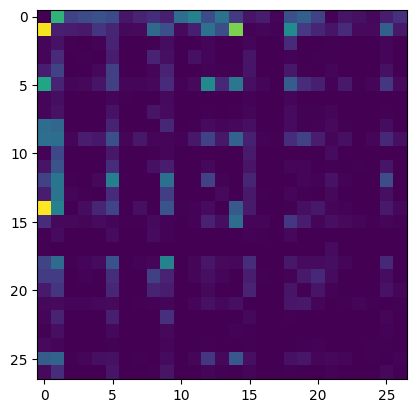

In [32]:
plt.imshow(N)

(-0.5, 26.5, 26.5, -0.5)

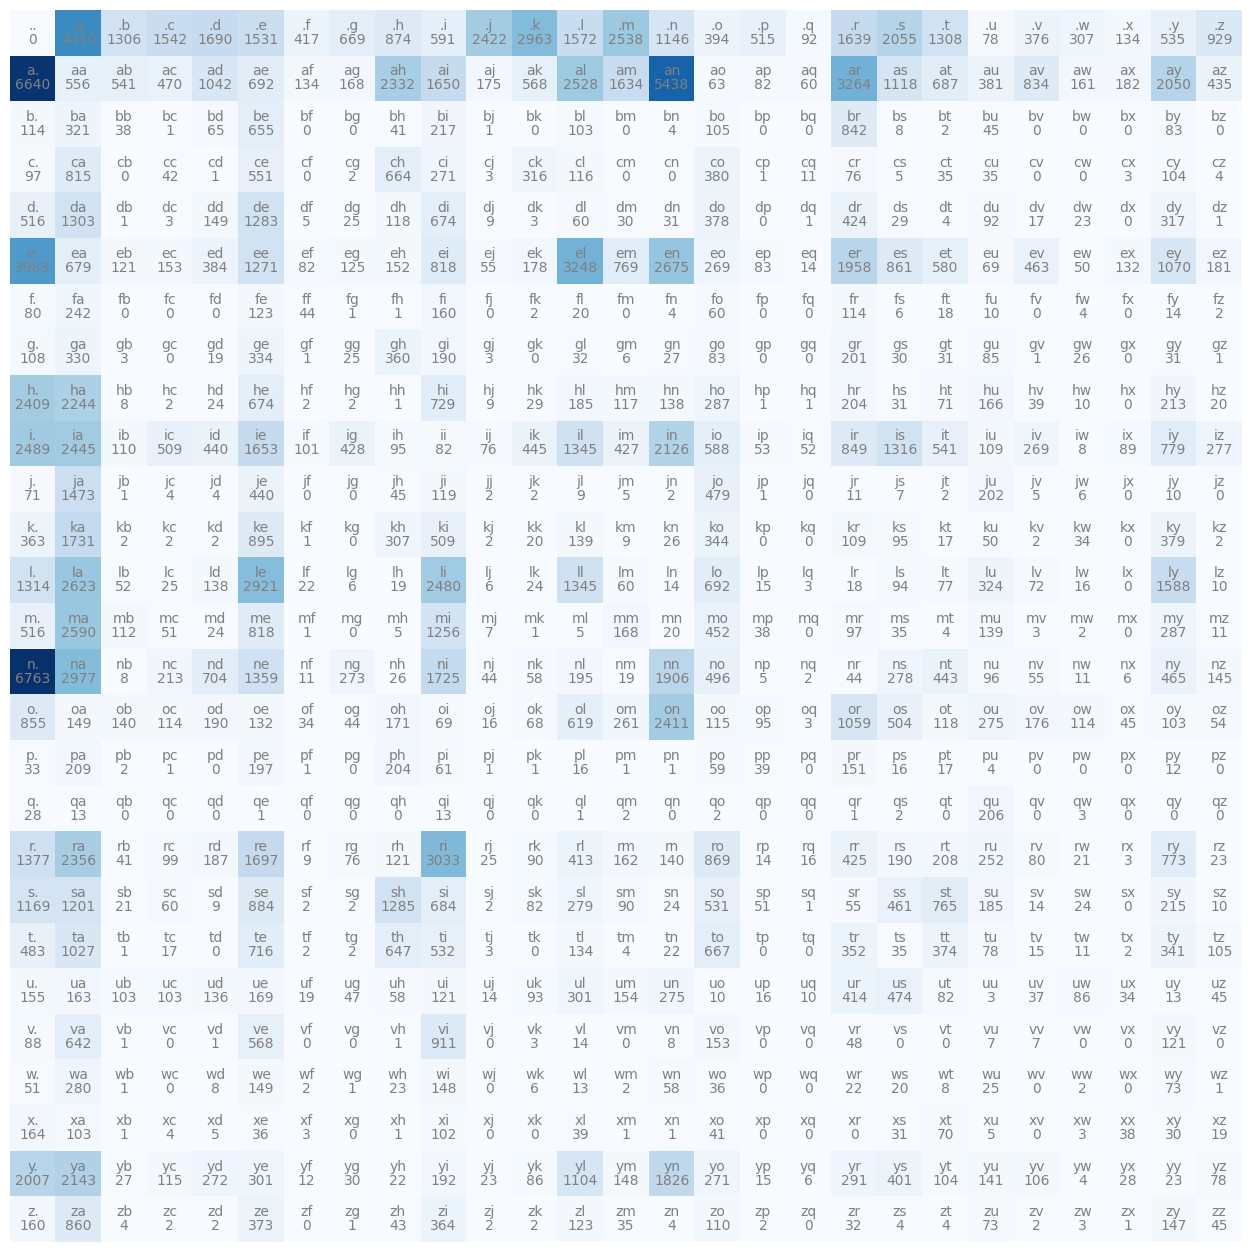

In [34]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i,j].item(), ha="center", va="top", color="gray")
plt.axis('off')

In [36]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

In [41]:
P = N.float()
P = P / P.sum(1, keepdim=True)

In [223]:
g = torch.Generator().manual_seed(2147483647)

outs = []

for i in range(50):
    out = []
    ix = 0
    while True:
        
        p = P[ix]
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    outs.append(out)
    print(''.join(out))

cexze.
momasurailezitynn.
konimittain.
llayn.
ka.
da.
staiyaubrtthrigotai.
moliellavo.
ke.
teda.
ka.
emimmsade.
enkaviyny.
ftlspihinivenvorhlasu.
dsor.
br.
jol.
pen.
aisan.
ja.
feniee.
zem.
deru.
firit.
gaikajahahbevare.
kiysthelenaririenah.
keen.
x.
al.
kal.
thavazeeromysos.
laitenimieegariseriyen.
k.
illeleldole.
meenisammigama.
mmin.
asharin.
alcalar.
jayn.
asaz.
selanely.
chay.
rana.
ai.
yviamisashougen.
l.
beyncaro.
allan.
annutetoradrilia.
rddeman.


In [74]:
llhs = []
for word in outs[:3]:
    llh = 0.0
    
    for ch1, ch2 in zip(word,word[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        
        llh += -torch.log(P[ix1, ix2])
    
    llhs.append(llh)

In [76]:
n = 0
llh = 0
for w in words[:3]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        llh += -torch.log(P[ix1, ix2])
        n += 1
        print(f"{ch1}{ch2} | {P[ix1, ix2]:.4f} | {llh}")
        
print(f"llh: {llh:.4f}")
print(f"Avg llh: {llh/n:.4f}")

.e | 0.0478 | 3.0408456325531006
em | 0.0377 | 6.320171356201172
mm | 0.0253 | 9.99737548828125
ma | 0.3899 | 10.939130783081055
a. | 0.1960 | 12.568991661071777
.o | 0.0123 | 16.9671630859375
ol | 0.0780 | 19.51797103881836
li | 0.1777 | 21.245765686035156
iv | 0.0152 | 25.432430267333984
vi | 0.3541 | 26.470714569091797
ia | 0.1381 | 28.45029067993164
a. | 0.1960 | 30.080150604248047
.a | 0.1377 | 32.06304168701172
av | 0.0246 | 35.76753616333008
va | 0.2495 | 37.15577697753906
a. | 0.1960 | 38.78563690185547
llh: 38.7856
Avg llh: 2.4241


In [75]:
sum(llhs)/3

tensor(27.5275)

In [211]:
# Create training set of bigrams

xs, ys = [], []

for w in words:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("Number of examples: ", num)

# initialization
g = torch.Generator().manual_seed(2147483647)
W = torch.randn([27,27], generator=g, requires_grad=True)



Number of examples:  228146


In [220]:
# gradient descent
from datetime import datetime as dt
before = dt.now()

xs = xs.to('mps')
ys = ys.to('mps')
W = W.to('mps')
W.retain_grad()

for k in range(1000):

    # forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = (xenc @ W)
    counts = logits.exp()
    probs = counts / counts.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean() + 0.01*(W**2).mean()
    if k % 50 == 0:
        print(f"Loss at {k} is {loss: .4f}")
    
    # backward pass
    W.grad = None
    loss.backward()
    
    # update
    W.data += -5 * W.grad

print(dt.now() - before)

Loss at 0 is  2.5031
Loss at 50 is  2.5004
Loss at 100 is  2.4982
Loss at 150 is  2.4963
Loss at 200 is  2.4947
Loss at 250 is  2.4933
Loss at 300 is  2.4921
Loss at 350 is  2.4910
Loss at 400 is  2.4901
Loss at 450 is  2.4893
Loss at 500 is  2.4886
Loss at 550 is  2.4879
Loss at 600 is  2.4874
Loss at 650 is  2.4869
Loss at 700 is  2.4864
Loss at 750 is  2.4860
Loss at 800 is  2.4856
Loss at 850 is  2.4853
Loss at 900 is  2.4850
Loss at 950 is  2.4847
0:00:11.168154


In [221]:
# Generate new names

g = torch.Generator().manual_seed(2147483647)

W = W.to('cpu')

for i in range(5):
    out = []
    ix = 0
    while True:
        
#         p = P[ix]

        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        counts = logits.exp()
        p = counts / counts.sum(1, keepdims=True)
        
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    outs.append(out)
    print(''.join(out))

cexze.
momasurailezityha.
konimittain.
llayn.
ka.


### MLP model

In [491]:
# variables

block_size = 3
embed_dims = 10
N1 = 250
reg = 0.2


In [470]:
# build the dataset

X, Y = [], []
for w in words:
    word = ['.'] * block_size + list(w) + ['.']
    windows = [word[i:] for i in range(block_size + 1)]
    for chs in zip(*windows):
        chs = list(map(lambda e: stoi[e], chs))
        X.append(chs[:-1])
        Y.append(chs[-1])
        
X = torch.tensor(X)
Y = torch.tensor(Y)

In [564]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182512, 3]) torch.Size([182512])
torch.Size([22860, 3]) torch.Size([22860])
torch.Size([22774, 3]) torch.Size([22774])


In [572]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn([27,embed_dims], generator=g)#.to('mps')
W1 = torch.randn((block_size * embed_dims, N1), generator=g) * 0.2 #.to('mps')
# b1 = torch.randn(N1, generator=g) * 0.01 #.to('mps')
W2 = torch.randn((N1, 27), generator=g) * 0.01 #.to('mps')
b2 = torch.randn(27, generator=g) * 0 #.to('mps')

bngain = torch.ones((1, N1))
bnbias = torch.zeros((1, N1))
bnmean_running = torch.zeros((1, N1))
bnstd_running = torch.ones((1, N1))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

In [573]:
sum(p.nelement() for p in parameters)

15047

In [574]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [575]:
lrs[0]

tensor(0.0010)

In [576]:

# X = X.to('mps')
# Y = Y.to('mps')
# for p in parameters:
#    print(f"{p.device}")
    
# print(X.device)
# print(C.device)
# print(W1.device)

lri = []
lossi = []

before = dt.now()
for k in range(50000):
    
    # minibatch
    ixs = torch.randint(0, Xtr.shape[0], (256,))
    
    # forward pass
    emb = C[Xtr[ixs]]
    
    # linear layer
    hpre = emb.view(-1,block_size * embed_dims) @ W1
    
    # batchnorm layer
    bnmeani = hpre.mean(0, keepdims=True)
    bnstdi = hpre.std(0, keepdims=True)
    hpre = bngain * (hpre - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpre)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ixs]) + reg * torch.mean(W1**2) + reg * torch.mean(W2**2)
    
    if k % 250 == 0:
        print(f"Loss at {k} is {loss.item(): .4f}")
#         print(f"emb: {emb.device} | h: {h.device} | logits: {logits.device} | loss: {loss.device}")
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
#     lr = lrs[k]
    lr = 0.15 if k <= 30000 else 0.05 if k <= 45000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    lri.append(lr)
    lossi.append(loss.item())

print(dt.now() - before)

Loss at 0 is  3.2988
Loss at 250 is  2.4508
Loss at 500 is  2.2914
Loss at 750 is  2.4541
Loss at 1000 is  2.4619
Loss at 1250 is  2.2368
Loss at 1500 is  2.2923
Loss at 1750 is  2.2794
Loss at 2000 is  2.1725
Loss at 2250 is  2.1551
Loss at 2500 is  2.2417
Loss at 2750 is  2.3053
Loss at 3000 is  2.0924
Loss at 3250 is  2.2381
Loss at 3500 is  2.2379
Loss at 3750 is  2.2593
Loss at 4000 is  2.1452
Loss at 4250 is  2.1262
Loss at 4500 is  2.2856
Loss at 4750 is  2.1566
Loss at 5000 is  2.1148
Loss at 5250 is  2.1540
Loss at 5500 is  2.0991
Loss at 5750 is  2.1559
Loss at 6000 is  2.2056
Loss at 6250 is  2.1894
Loss at 6500 is  2.1245
Loss at 6750 is  2.1209
Loss at 7000 is  2.1375
Loss at 7250 is  2.1327
Loss at 7500 is  2.0948
Loss at 7750 is  2.2200
Loss at 8000 is  2.1366
Loss at 8250 is  2.1316
Loss at 8500 is  2.1835
Loss at 8750 is  2.0087
Loss at 9000 is  2.2513
Loss at 9250 is  2.0649
Loss at 9500 is  2.1481
Loss at 9750 is  2.2389
Loss at 10000 is  2.1827
Loss at 10250 is  2.1

In [555]:
emb = C[Xtr]
hpre = emb.view(-1,block_size * embed_dims) @ W1 + b1
hpre = (hpre - bnmean) / bnstd
hpre = bngain * hpre + bnbias
h = torch.tanh(hpre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0235, grad_fn=<NllLossBackward0>)

In [556]:
emb = C[Xdev]
hpre = emb.view(-1,block_size * embed_dims) @ W1 + b1
hpre = (hpre - hpre.mean(0, keepdims=True)) / hpre.std(0, keepdims=True)
hpre = bngain * hpre + bnbias
h = torch.tanh(hpre)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1004, grad_fn=<NllLossBackward0>)

In [554]:
# calibrate batch norm

with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpre = embcat @ W1 + b1
    
    # measure mean/std
    bnmean = hpre.mean(0, keepdims=True)
    bnstd = hpre.std(0, keepdims=True)

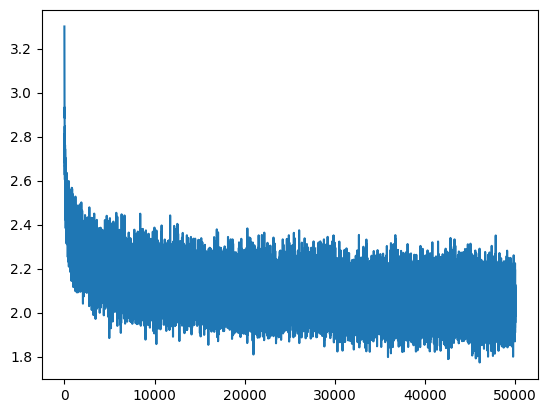

In [550]:
plt.plot(lossi)

In [543]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out))

carmah.
ambrilvi.
kimri.
rehtyn.
kanden.
jazonel.
delynn.
jareei.
ner.
kiah.
maiir.
kaleigh.
ham.
joce.
quinthorlin.
alianni.
waterri.
jarynix.
kael.
dus.


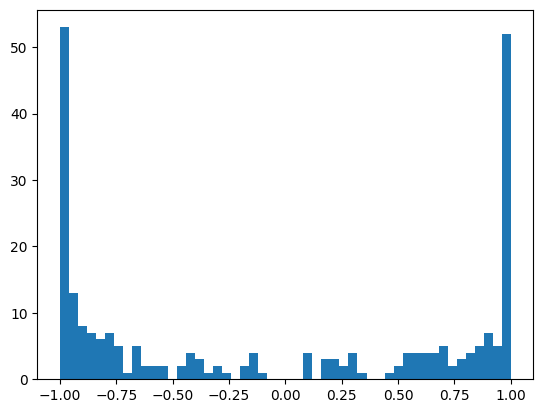

In [544]:
plt.hist(h.view(-1).tolist(), 50);

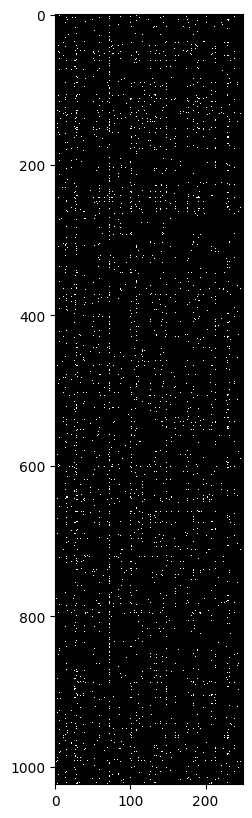

In [537]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

### Cleaned up MLP

In [580]:
# meta parameters

block_size = 3
vocab_size = 27

In [581]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182691, 3]) torch.Size([182691])
torch.Size([22793, 3]) torch.Size([22793])
torch.Size([22662, 3]) torch.Size([22662])


In [590]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # set batch stats
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # forward pass
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + \
                                    self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + \
                                   self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embed = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator = g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # lower confidence of final layer
    layers[-1].gamma *= 0.1
    # apply gain to others
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
                    
        

47551


In [595]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000: 3.2667


layer 2 (Tanh      ): mean -0.01, std 0.63, saturated: 2.78%
layer 5 (Tanh      ): mean -0.01, std 0.64, saturated: 2.59%
layer 8 (Tanh      ): mean -0.01, std 0.64, saturated: 2.00%
layer 11 (Tanh      ): mean -0.00, std 0.65, saturated: 1.88%
layer 14 (Tanh      ): mean -0.01, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

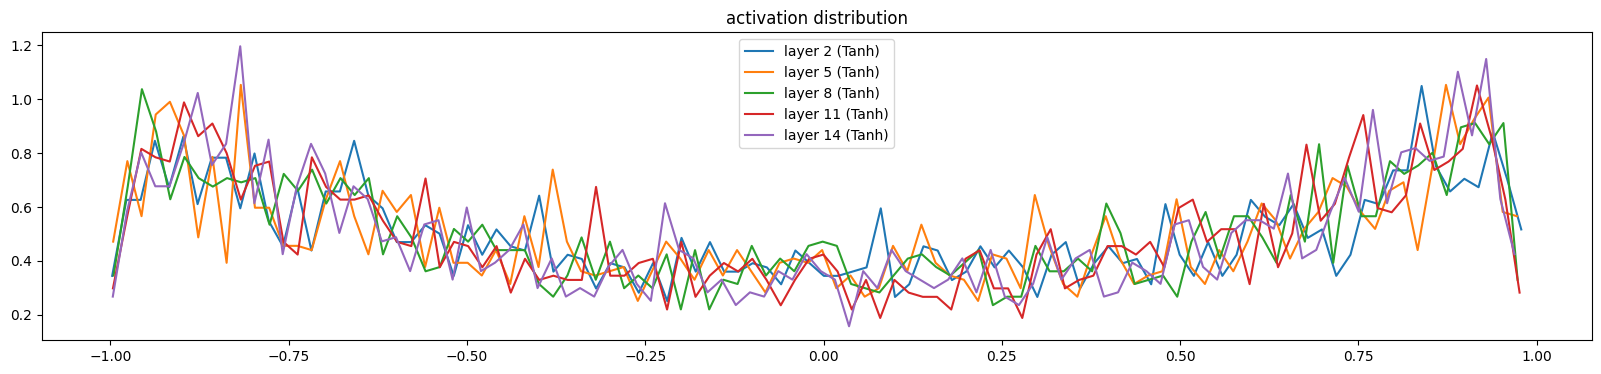

In [596]:
# visualize weight
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+.2f}, std {t.std():.2f}, " + \
              f"saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (Tanh      ): mean -0.000000, std 3.255213e-03
layer 5 (Tanh      ): mean -0.000000, std 2.858473e-03
layer 8 (Tanh      ): mean -0.000000, std 2.800514e-03
layer 11 (Tanh      ): mean +0.000000, std 2.759438e-03
layer 14 (Tanh      ): mean +0.000000, std 2.662558e-03


Text(0.5, 1.0, 'gradient distribution')

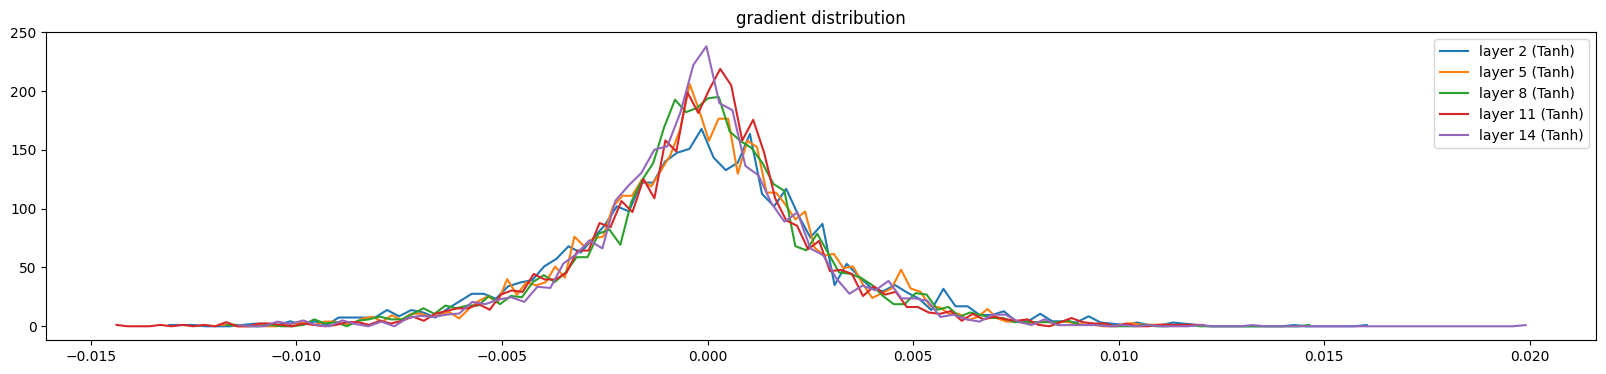

In [597]:
# visualize grad
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+f}, std {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight (27, 10) | mean +0.000 | std 9.034e-03 | grad:data ratio 9.025e-03
weight (30, 100) | mean -0.000 | std 7.214e-03 | grad:data ratio 2.308e-02
weight (100, 100) | mean +0.000 | std 6.061e-03 | grad:data ratio 3.625e-02
weight (100, 100) | mean -0.000 | std 5.295e-03 | grad:data ratio 3.140e-02
weight (100, 100) | mean +0.000 | std 5.272e-03 | grad:data ratio 3.141e-02
weight (100, 100) | mean -0.000 | std 5.221e-03 | grad:data ratio 3.109e-02
weight (100, 27) | mean -0.000 | std 1.037e-02 | grad:data ratio 6.217e-02


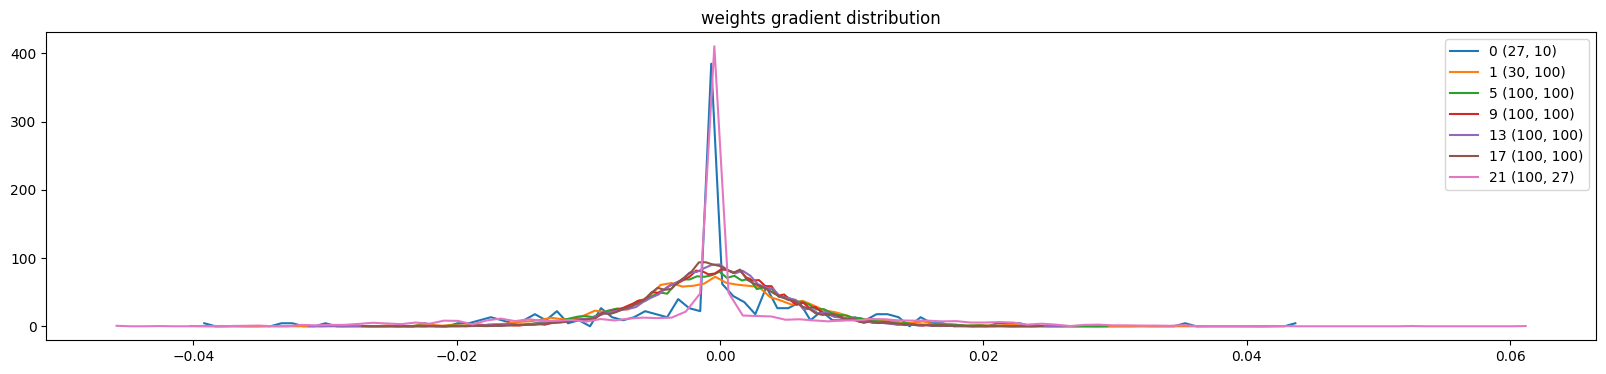

In [611]:
# visualize weights
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {tuple(p.shape)} | mean {t.mean():+.3f} | " + \
              f"std {t.std():.3e} | grad:data ratio {t.std() / p.std():.3e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

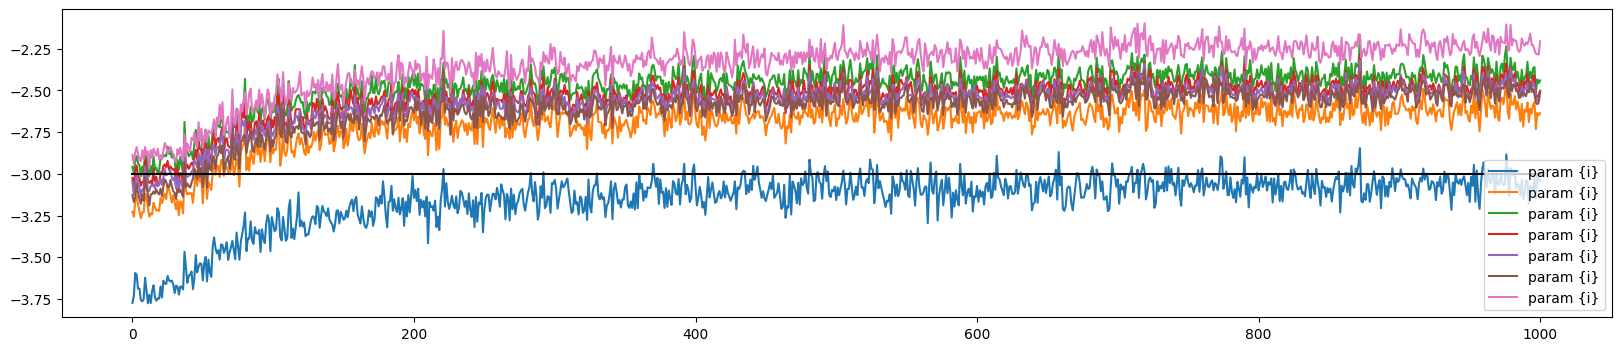

In [612]:
# visualize updates
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)

### Become a Backprop Ninja

In [613]:
# meta parameters

block_size = 3
vocab_size = 27

In [614]:
def build_dataset(words, block_size):
    X, Y = [], []
    for w in words:
        
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1], block_size)
Xdev, Ydev = build_dataset(words[n1:n2], block_size)
Xte, Yte = build_dataset(words[n2:], block_size)

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22740, 3]) torch.Size([22740])
torch.Size([22826, 3]) torch.Size([22826])


In [ ]:
def cmp(s, dt, t):
    ex = torch.all(dt == t.grad).item()
    app = torch.allclose(dt, t.grad)
    maxdiff = (dt - t.grad).abs().max().item()
    print(f"{s:15s} | exact: {str(ex):5s} | approximate: {str(app):5s} | maxdiff: {maxdiff}")

In [621]:
n_embed = 10
n_hidden = 64

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embed))
# Layer 1
W1 = torch.randn((n_embed * block_size, n_hidden), generator = g) * (5/3)/((n_embed * block_size)**0.5)
b1 = torch.randn(n_hidden, generator = g) * 0.1

# Layer 2
W2 = torch.randn((n_hidden, vocab_size), generator = g) * 0.1
b2 = torch.randn(vocab_size, generator = g) * 0.1

# BatchNorm
bngain = torch.randn((1, n_hidden)) * 0.1 + 1.0
bnbias = torch.randn((1, n_hidden)) * 0.1

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


4137


In [622]:
batch_size = 32
n = batch_size

# minibatch
ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator = g)
Xb, Yb = Xtr[ix], Ytr[ix]

In [615]:
class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        
        # parameters
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        
        # buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        
        # set batch stats
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        # forward pass
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        
        # update
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + \
                                    self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + \
                                   self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []
    

n_embed = 10
n_hidden = 100

g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embed), generator = g)
layers = [
    Linear(n_embed * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # lower confidence of final layer
    layers[-1].gamma *= 0.1
    # apply gain to others
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True
                    
        

47551


In [616]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)
    
    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100_000 else 0.01 # step decay
    for p in parameters:
        p.data += -lr * p.grad
        
    # tracking
    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    if i >= 1000:
        break
    

      0/ 200000: 3.2899


layer 2 (Tanh      ): mean -0.00, std 0.63, saturated: 2.88%
layer 5 (Tanh      ): mean -0.00, std 0.64, saturated: 2.50%
layer 8 (Tanh      ): mean -0.01, std 0.64, saturated: 2.47%
layer 11 (Tanh      ): mean -0.00, std 0.64, saturated: 2.22%
layer 14 (Tanh      ): mean -0.01, std 0.64, saturated: 2.41%


Text(0.5, 1.0, 'activation distribution')

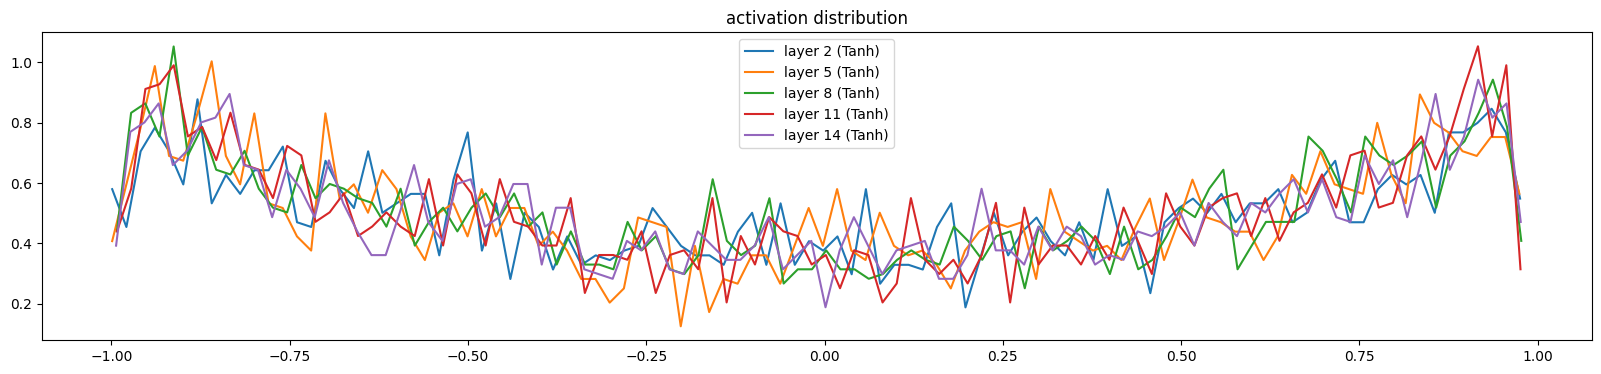

In [617]:
# visualize weight
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+.2f}, std {t.std():.2f}, " + \
              f"saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("activation distribution")

layer 2 (Tanh      ): mean +0.000000, std 3.828418e-03
layer 5 (Tanh      ): mean -0.000000, std 3.106622e-03
layer 8 (Tanh      ): mean -0.000000, std 2.814896e-03
layer 11 (Tanh      ): mean +0.000000, std 2.566039e-03
layer 14 (Tanh      ): mean +0.000000, std 2.349659e-03


Text(0.5, 1.0, 'gradient distribution')

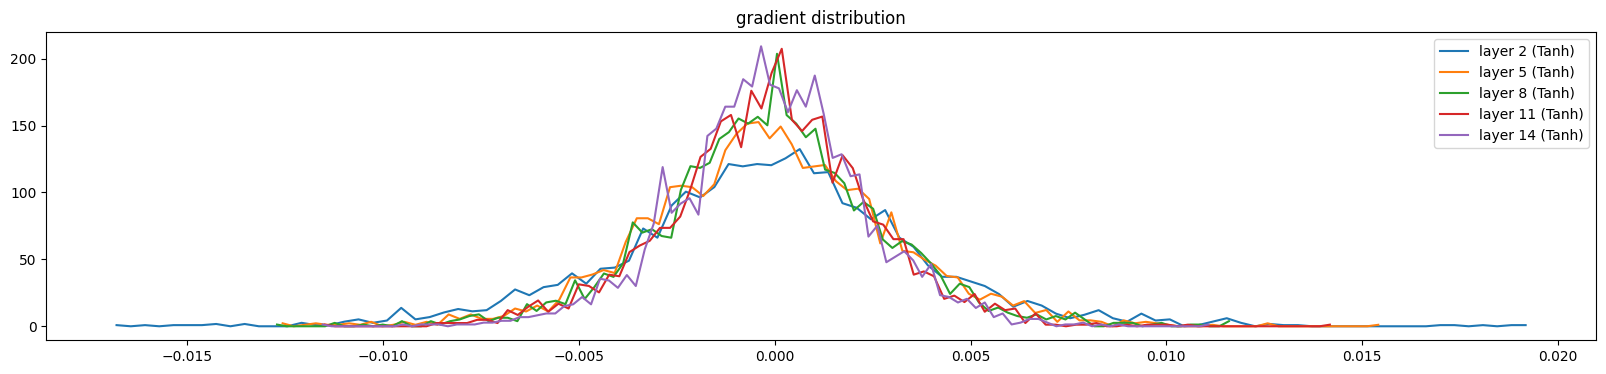

In [618]:
# visualize grad
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]):
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f"layer {i} ({layer.__class__.__name__:10s}): " + \
              f"mean {t.mean():+f}, std {t.std():e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"layer {i} ({layer.__class__.__name__})")
plt.legend(legends)
plt.title("gradient distribution")

weight (27, 10) | mean -0.000 | std 1.292e-02 | grad:data ratio 1.290e-02
weight (30, 100) | mean -0.000 | std 1.050e-02 | grad:data ratio 3.358e-02
weight (100, 100) | mean +0.000 | std 8.071e-03 | grad:data ratio 4.827e-02
weight (100, 100) | mean +0.000 | std 7.005e-03 | grad:data ratio 4.153e-02
weight (100, 100) | mean -0.000 | std 6.416e-03 | grad:data ratio 3.822e-02
weight (100, 100) | mean -0.000 | std 5.288e-03 | grad:data ratio 3.149e-02
weight (100, 27) | mean +0.000 | std 9.934e-03 | grad:data ratio 5.957e-02


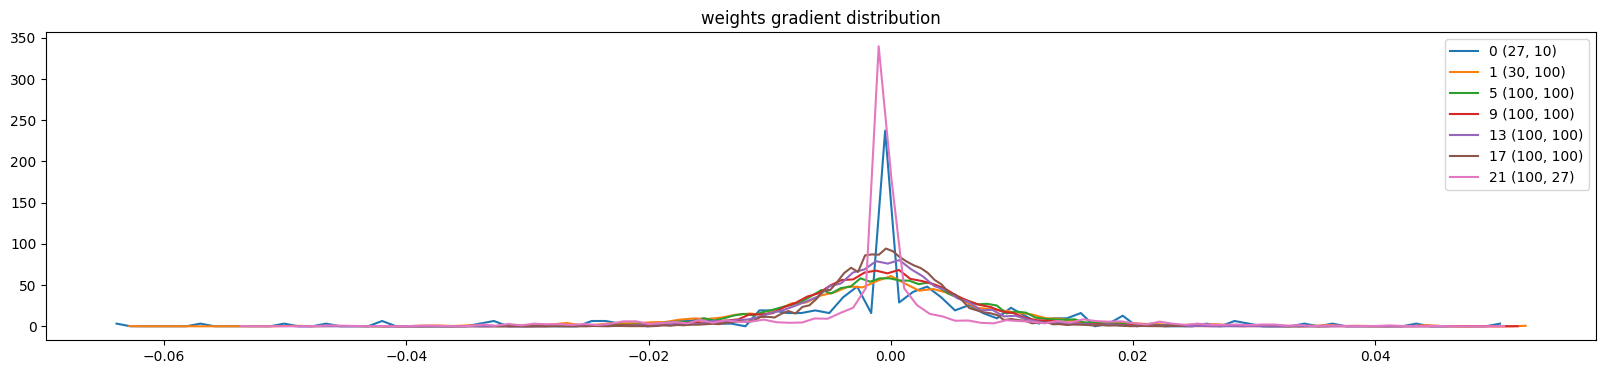

In [619]:
# visualize weights
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f"weight {tuple(p.shape)} | mean {t.mean():+.3f} | " + \
              f"std {t.std():.3e} | grad:data ratio {t.std() / p.std():.3e}")
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f"{i} {tuple(p.shape)}")
plt.legend(legends)
plt.title("weights gradient distribution");

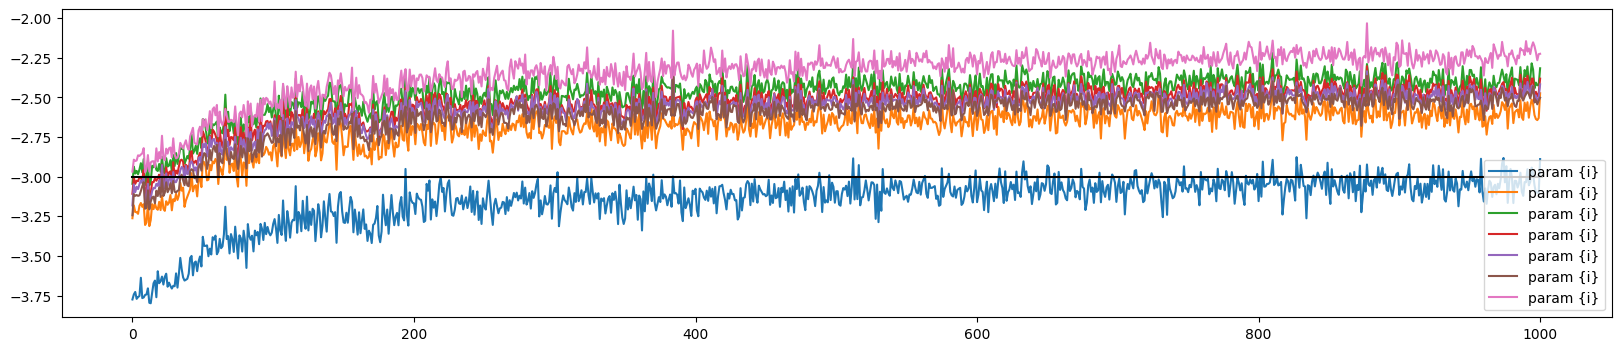

In [620]:
# visualize updates
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append("param {i}")
plt.plot([0, len(ud)], [-3, -3], "k")
plt.legend(legends)